In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [11]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
classes = ['fire', 'non-fire']

In [12]:
datagen = ImageDataGenerator(rescale=1./255)
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='binary')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='binary',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='binary',
    shuffle=False)

Found 2483 images belonging to 2 classes.
Found 310 images belonging to 2 classes.
Found 311 images belonging to 2 classes.


In [22]:
model = tf.keras.models.load_model('saved_models/model_inceptionv3.hdf5')

In [23]:
score = model.evaluate(test_ds, verbose=1)
print(f'Loss: {score[0]}, Accuracy: {score[1]*100}')

10/10 [==============================] - 2s 127ms/step - loss: 0.1014 - accuracy: 0.9807
Loss: 0.10135819762945175, Accuracy: 98.07074069976807


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
test_steps_per_epoch = np.math.ceil(test_ds.samples / test_ds.batch_size)
Y_pred = model.predict(test_ds, steps = test_steps_per_epoch)
prediction = [1* (x[0]>=0.5) for x in Y_pred]

In [25]:
test_ds.class_indices = ['fire', 'non-fire']

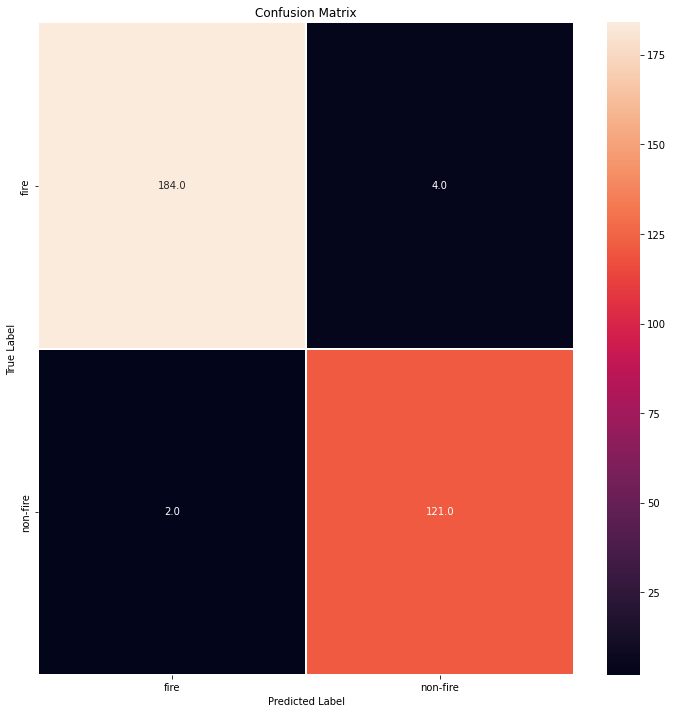

In [26]:
confusion_mtx = confusion_matrix(prediction, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(classes)
plt.title("Confusion Matrix")
plt.show()

In [27]:
report1 = classification_report(test_ds.classes, prediction, target_names=classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
fire,0.978723,0.989247,0.983957,186.000000
non-fire,0.983740,0.968000,0.975806,125.000000
accuracy,0.980707,0.980707,0.980707,0.980707
macro avg,0.981232,0.978624,0.979882,311.000000
weighted avg,0.980740,0.980707,0.980681,311.000000


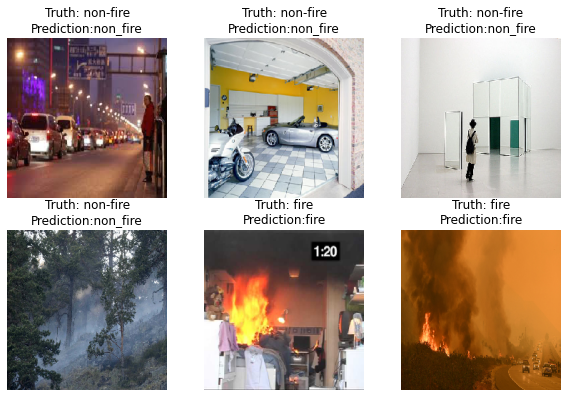

In [32]:
plt.figure(figsize=(10, 10))
for i in range(6):
    x, label= test_ds.next()
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = int(label[i])
    predict = model(tf.expand_dims(x[i], 0))
    if predict > 0.5:
        score = 'non_fire'
    else:
        score = 'fire'

    score_label = classes[np.argmax(score)]
    plt.title(f'Truth: {classes[result]}\nPrediction:{score}')
    plt.axis(False)